In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [2]:
torch.linspace(0, 1, 5+1)

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000])

In [3]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 0.05 * mm,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}


#optim_params = {
#    'c_s': 400,
#    'tau_max': 3.5,
#    'tau_min': 1.5
#}

torch.Size([1, 1, 345, 454])


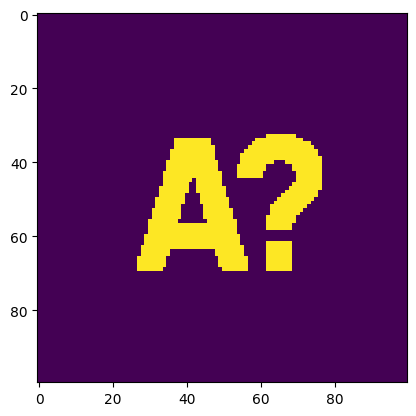

In [4]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo.png').convert('L'))
target1 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
target1 = F.pad(input=target1, pad=(140, 140, 140, 140), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[100, 100])
plt.imshow(target1[0,0,:,:])

torch.Size([1, 1, 200, 200])


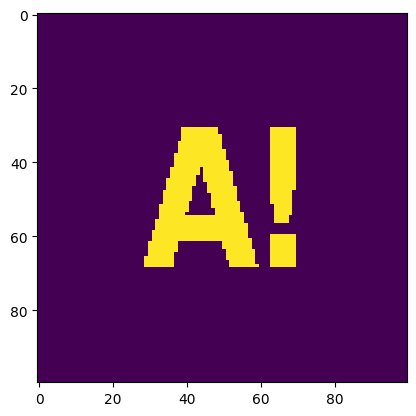

In [5]:
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo2.png').convert('L'))
target2 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target2 = normalize(target2)
print(target2.shape)
target2 = F.pad(input=target2, pad=(90, 90, 90, 90), mode='constant', value=0)
target2 = nn.functional.interpolate(torch.round(target2), size=[100, 100])
plt.imshow(target2[0,0,:,:])

# 2. Define the System with SoftGumbelQuantizedDOE 

In [6]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source  = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        #self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
        #                    bandlimit_type='exact', 
        #                    padding_scale=2, 
        #                    bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [12]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [13]:
max_itrs = 12000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.008)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.1)
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    #scheduler.step()
    if itr % 100 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.12429019808769226
The iteration : 100, Loss: 0.055341266095638275
The iteration : 200, Loss: 0.0430305190384388
The iteration : 300, Loss: 0.036688949912786484
The iteration : 400, Loss: 0.03485498204827309
The iteration : 500, Loss: 0.033053845167160034
The iteration : 600, Loss: 0.032094672322273254
The iteration : 700, Loss: 0.029979366809129715
The iteration : 800, Loss: 0.02921430952847004
The iteration : 900, Loss: 0.028374163433909416
The iteration : 1000, Loss: 0.028025079518556595
The iteration : 1100, Loss: 0.02801336720585823
The iteration : 1200, Loss: 0.027323149144649506
The iteration : 1300, Loss: 0.026015814393758774
The iteration : 1400, Loss: 0.0263921320438385
The iteration : 1500, Loss: 0.02593895047903061
The iteration : 1600, Loss: 0.025464769452810287
The iteration : 1700, 

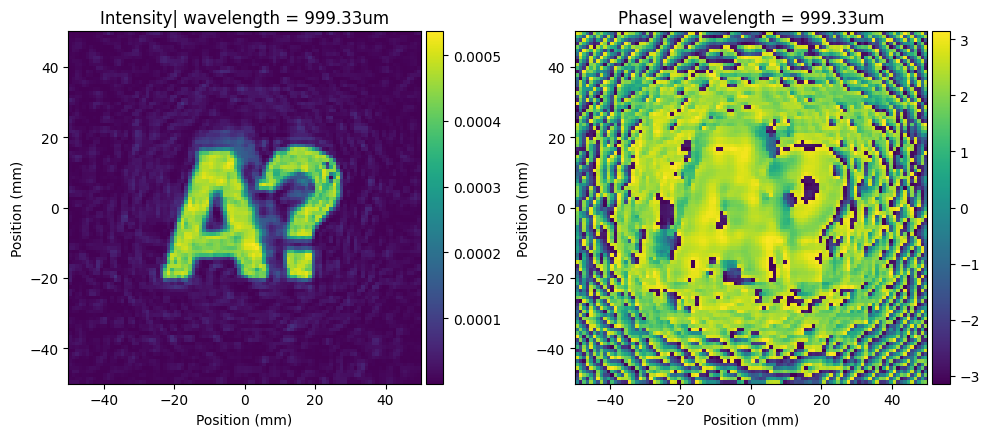

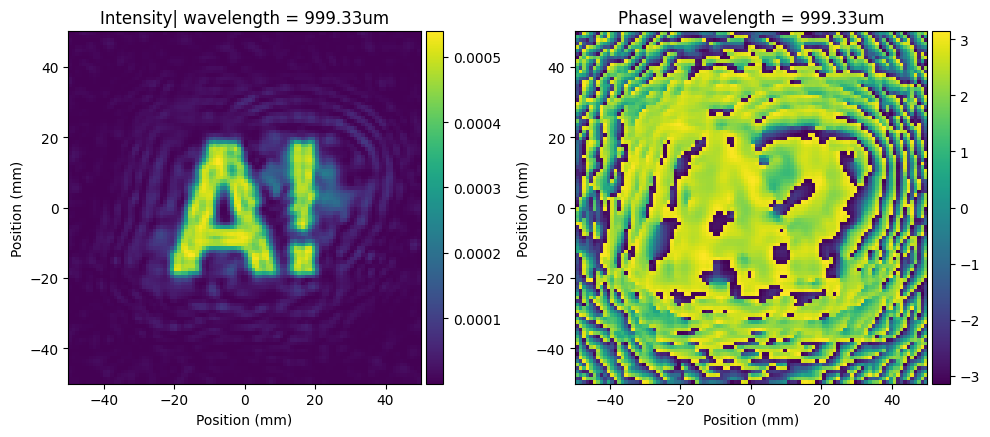

In [18]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

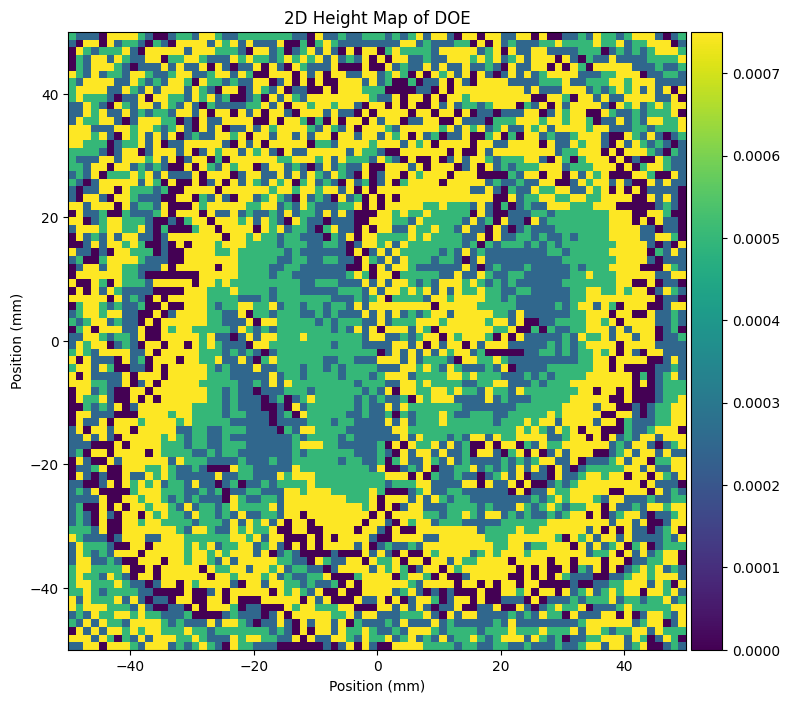

In [20]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[80, 80])

In [23]:
best_setup.doe.save(crop_size=[80, 80])

In [24]:
data = np.load('height_map_20240815-135819.npy', allow_pickle=True)
thickness = data.item().get('thickness')
dxy = data.item().get('dxy')
#plt.imshow(thickness)
DOE_xyz_cordinates_Generator(thickness, dxy, new_dxy=dxy)

The physical length of hologram is 80.0 mm
80


In [16]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

# 3. Define the System with FullPrecisionDOE

In [15]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [16]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [17]:
max_itrs = 5000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.16209085285663605
The iteration : 200, Loss: 0.054399505257606506
The iteration : 400, Loss: 0.04160922020673752
The iteration : 600, Loss: 0.03710614889860153
The iteration : 800, Loss: 0.034406982362270355
The iteration : 1000, Loss: 0.030797172337770462
The iteration : 1200, Loss: 0.029843252152204514
The iteration : 1400, Loss: 0.02900552563369274
The iteration : 1600, Loss: 0.028423625975847244
The iteration : 1800, Loss: 0.02807266265153885
The iteration : 2000, Loss: 0.027747511863708496
The iteration : 2200, Loss: 0.026345763355493546
The iteration : 2400, Loss: 0.025583025068044662
The iteration : 2600, Loss: 0.02552497759461403
The iteration : 2800, Loss: 0.025211285799741745
The iteration : 3000, Loss: 0.025767255574464798
The iteration : 3200, Loss: 0.02426663227379322
The iteration :

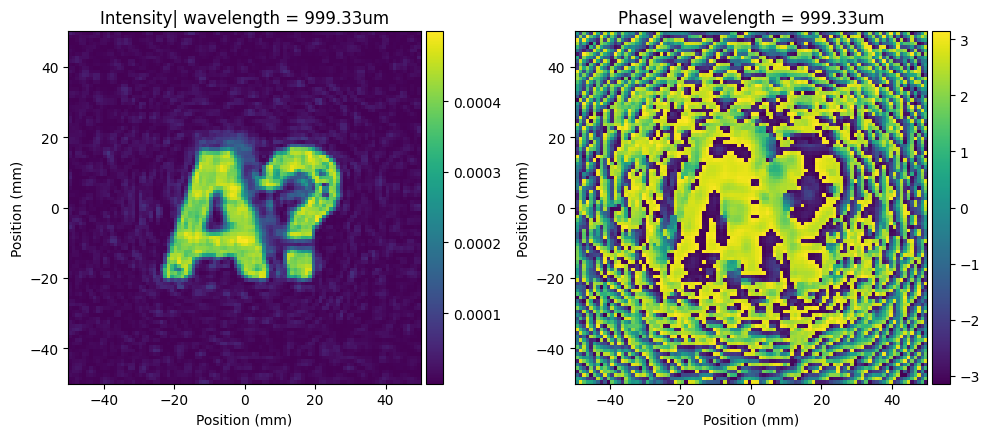

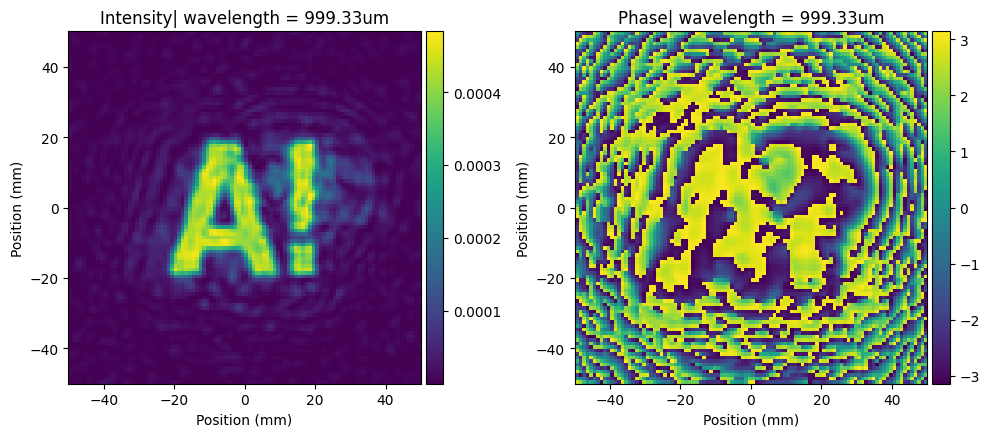

In [18]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

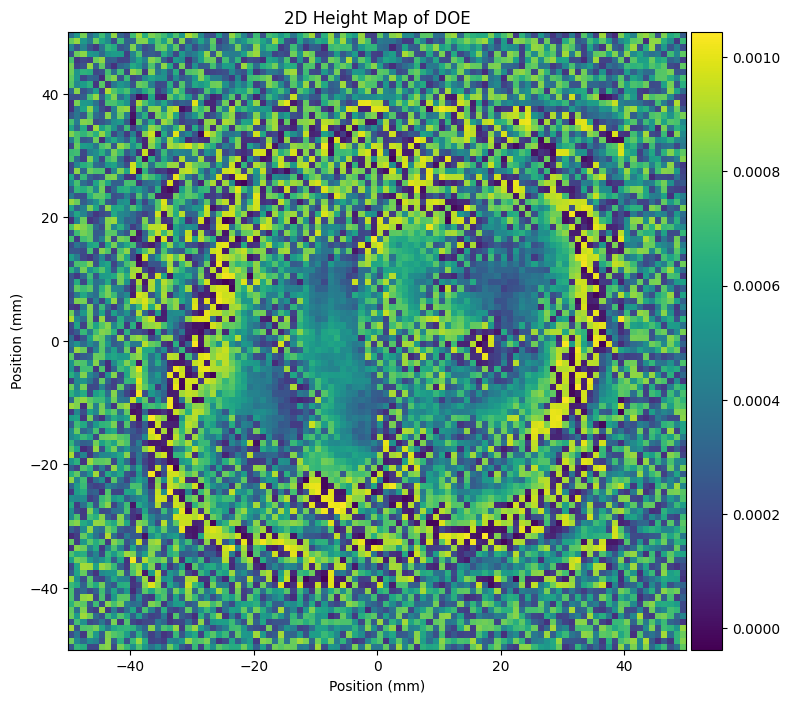

In [19]:
setup.doe.visualize(figsize=(8,8))

# 4. System with NaiveGumbelQuantizedDOELayer

In [20]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [21]:
optim_params = {
    'c_s': 500,
    'tau_max': 5.5,
    'tau_min': 1.0
}

setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [22]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.14180248975753784
The iteration : 200, Loss: 0.10619427263736725
The iteration : 400, Loss: 0.09311193227767944
The iteration : 600, Loss: 0.08861811459064484
The iteration : 800, Loss: 0.08204352855682373
The iteration : 1000, Loss: 0.08387187868356705
The iteration : 1200, Loss: 0.08914899826049805
The iteration : 1400, Loss: 0.07450586557388306
The iteration : 1600, Loss: 0.07080215215682983
The iteration : 1800, Loss: 0.07203301042318344
The iteration : 2000, Loss: 0.07106826454401016
The iteration : 2200, Loss: 0.0638582855463028
The iteration : 2400, Loss: 0.06309821456670761
The iteration : 2600, Loss: 0.0741630345582962
The iteration : 2800, Loss: 0.07199950516223907
The iteration : 3000, Loss: 0.06388450413942337
The iteration : 3200, Loss: 0.05953720211982727
The iteration : 3400, Loss:

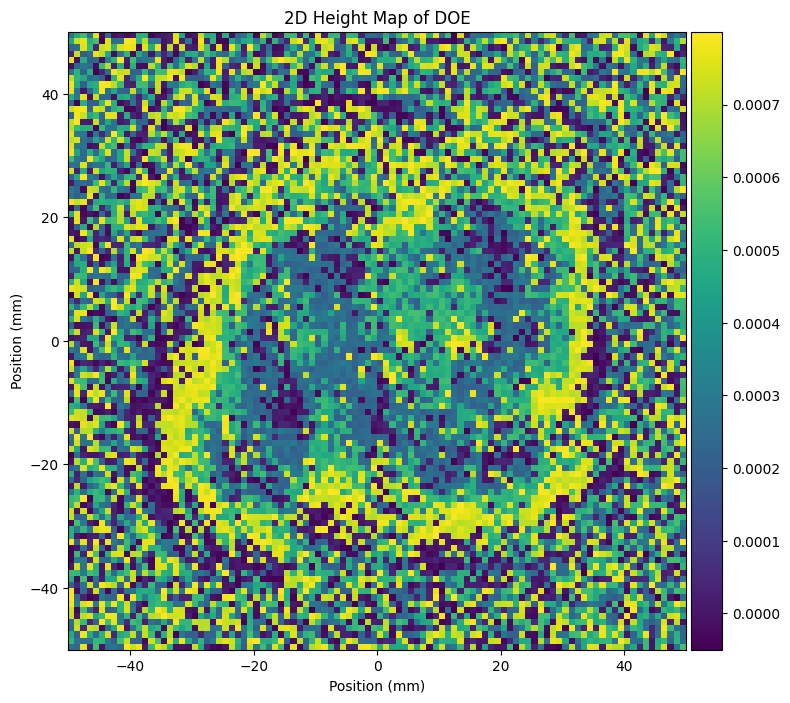

In [23]:
setup.doe.visualize(figsize=(8,8))

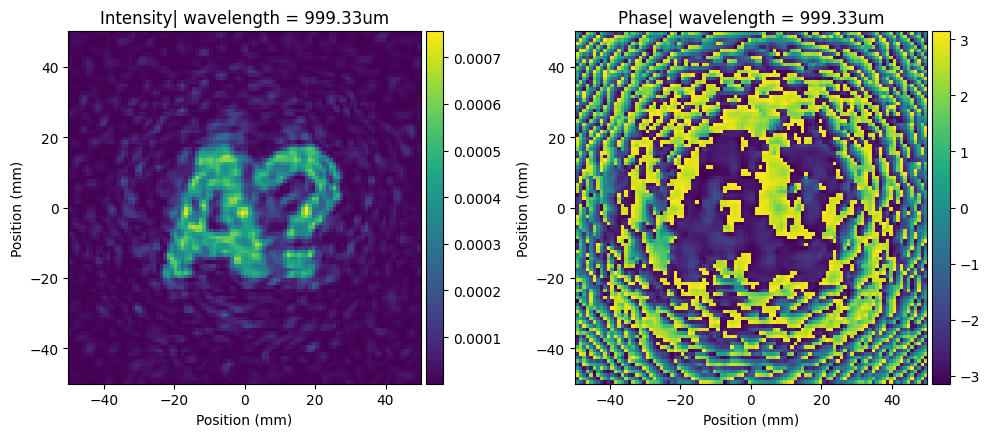

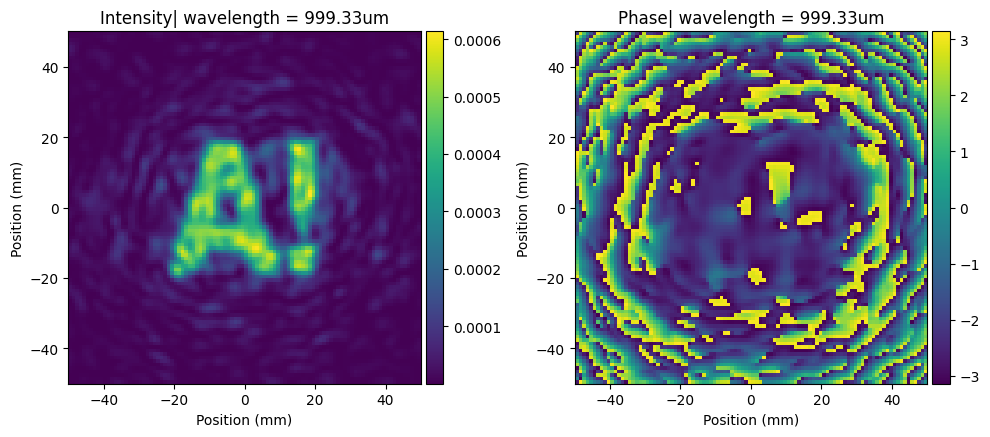

In [24]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

# 5. System with PSQuantizedDOELayer

In [25]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [26]:
optim_params = {
    'c_s': 300,
    'tau_max': 800,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [27]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.12157666683197021
The iteration : 200, Loss: 0.044665902853012085
The iteration : 400, Loss: 0.04172958433628082
The iteration : 600, Loss: 0.04132497310638428
The iteration : 800, Loss: 0.04272245615720749
The iteration : 1000, Loss: 0.042189523577690125
The iteration : 1200, Loss: 0.042272455990314484
The iteration : 1400, Loss: 0.043165870010852814
The iteration : 1600, Loss: 0.0435107946395874
The iteration : 1800, Loss: 0.04403083771467209
The iteration : 2000, Loss: 0.043915629386901855
The iteration : 2200, Loss: 0.04326777160167694
The iteration : 2400, Loss: 0.0438920222222805
The iteration : 2600, Loss: 0.043654635548591614
The iteration : 2800, Loss: 0.04296231269836426
The iteration : 3000, Loss: 0.04355940222740173
The iteration : 3200, Loss: 0.04277627542614937
The iteration : 3400,

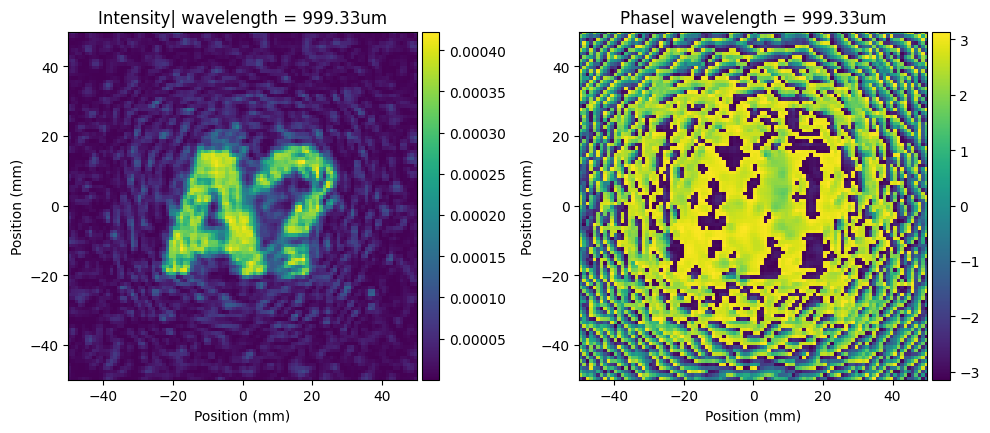

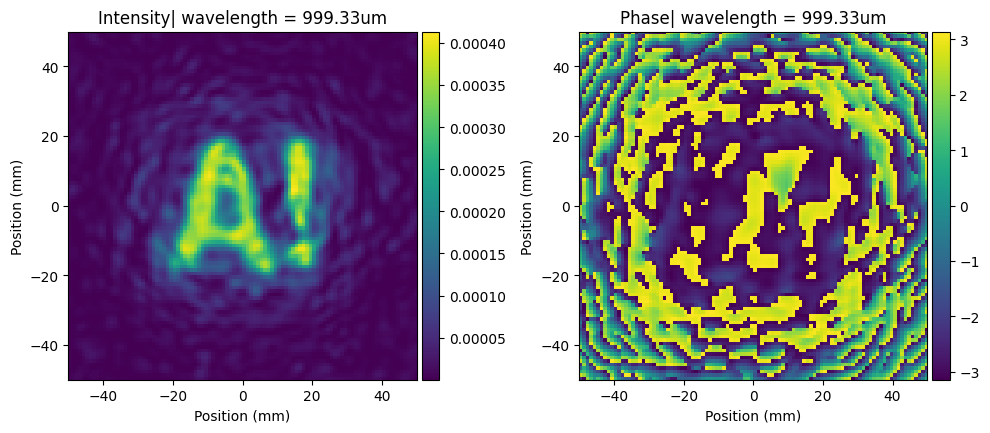

In [28]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

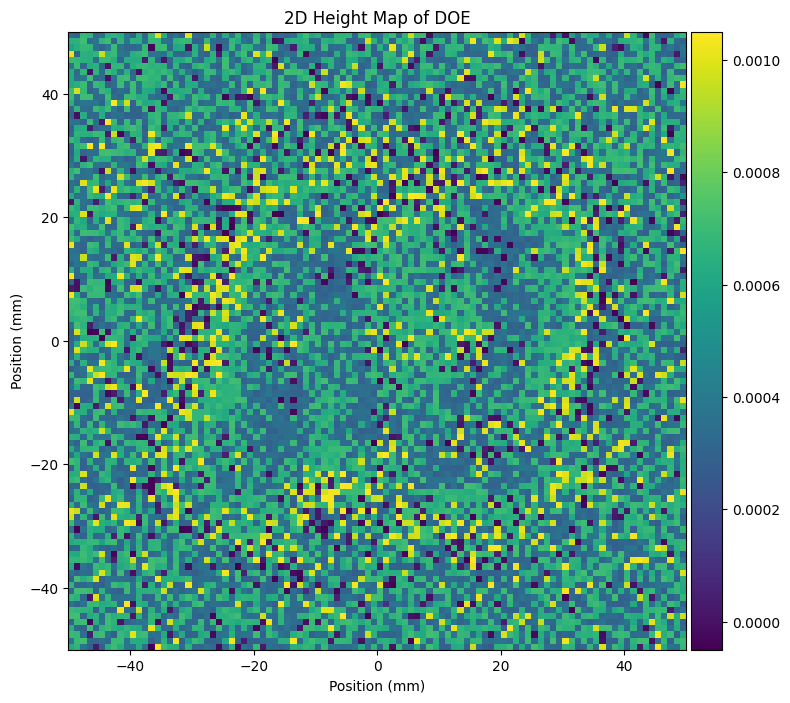

In [29]:
setup.doe.visualize(figsize=(8,8))

# 6. System with STEQuantizedDOELayer 

In [30]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [31]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [32]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.12958408892154694
The iteration : 200, Loss: 0.04910866916179657
The iteration : 400, Loss: 0.04230548441410065
The iteration : 600, Loss: 0.040197934955358505
The iteration : 800, Loss: 0.03976709395647049
The iteration : 1000, Loss: 0.03835972398519516
The iteration : 1200, Loss: 0.03865393251180649
The iteration : 1400, Loss: 0.036335356533527374
The iteration : 1600, Loss: 0.03920559585094452
The iteration : 1800, Loss: 0.03767108917236328
The iteration : 2000, Loss: 0.033792898058891296
The iteration : 2200, Loss: 0.03417964279651642
The iteration : 2400, Loss: 0.03551414608955383
The iteration : 2600, Loss: 0.03453461825847626
The iteration : 2800, Loss: 0.033842943608760834
The iteration : 3000, Loss: 0.038325875997543335
The iteration : 3200, Loss: 0.035170771181583405
The iteration : 340

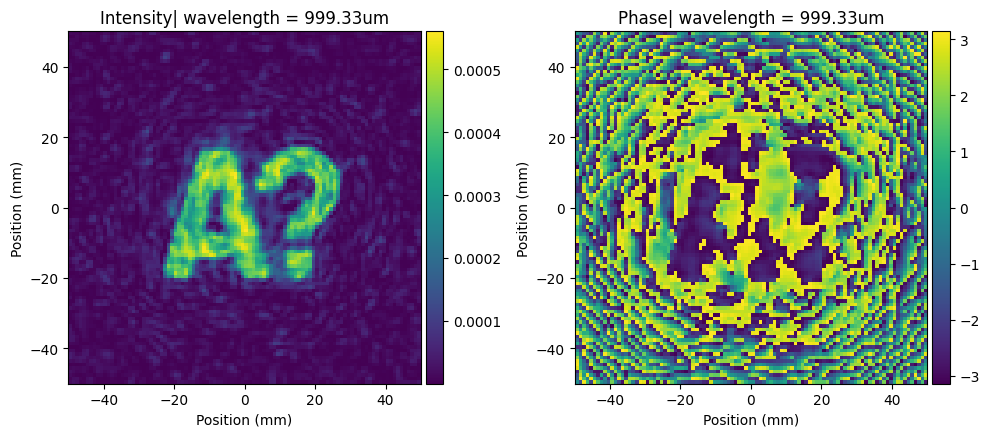

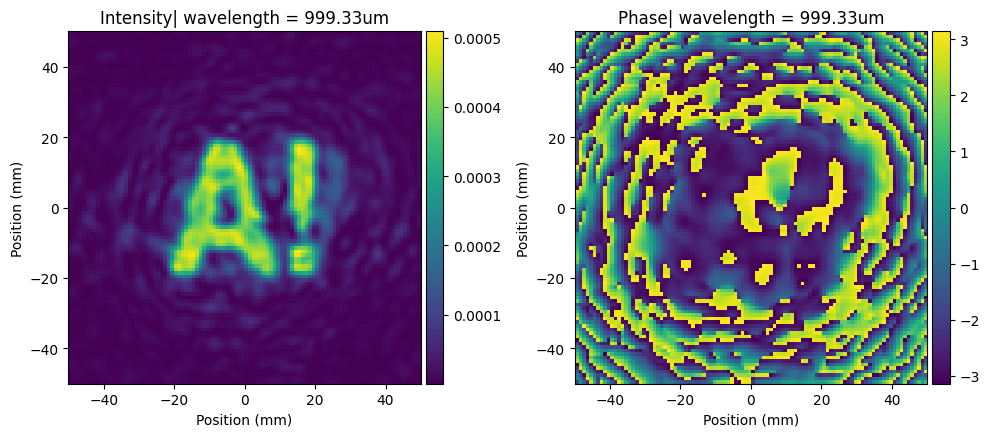

In [33]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

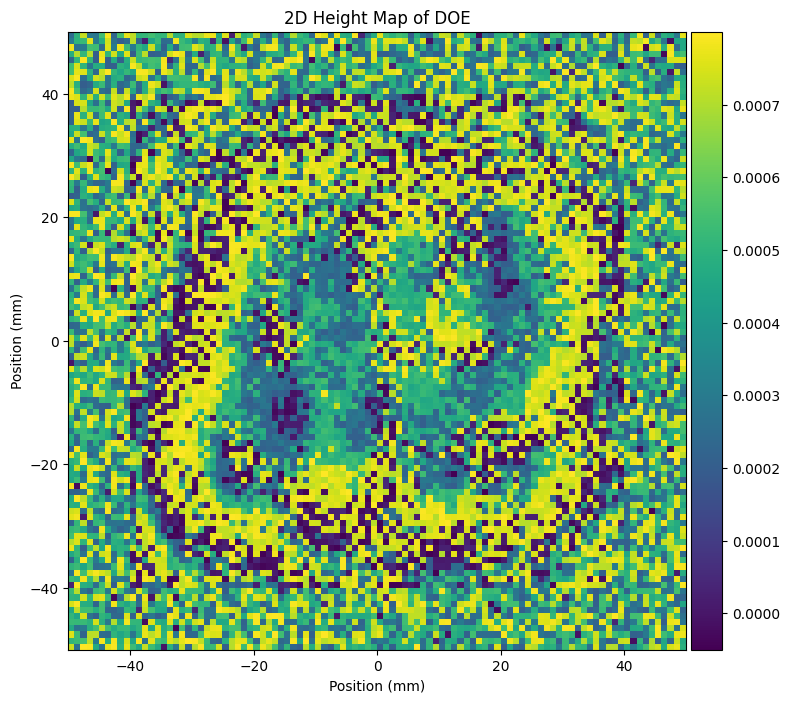

In [34]:
setup.doe.visualize(figsize=(8,8))

In [35]:
setup.doe.height_map.unique()

tensor([0.0000, 0.0003, 0.0005, 0.0008], device='cuda:0',
       grad_fn=<Unique2Backward0>)

## 1. Visualize for 1D distribution False

In [8]:
#out_amp = normalize(torch.abs(out_field.data)**2)

In [61]:
# 1D distribution for spot 1 and 2
from utils.Visualization_Helper import float_to_unit_identifier, add_colorbar
"""
size_x = np.array(1 * mm * 200 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
x_axis_spot_1_2 = out_amp[0, 0, :, 50]
x_axis_spot_1_2 = x_axis_spot_1_2.detach().numpy()
new_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))
plt.plot(new_x_axis, x_axis_spot_1_2)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")

plt.subplot(1, 2, 2)
x_axis_spot_3_4 = out_amp[0, 0, :, 150]
x_axis_spot_3_4 = x_axis_spot_3_4.detach().numpy()
plt.plot(new_x_axis, x_axis_spot_3_4)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")
plt.tight_layout()
"""

'\nsize_x = np.array(1 * mm * 200 / 2)\nunit_val, unit_axis = float_to_unit_identifier(size_x)\nsize_x = size_x / unit_val\n\nplt.figure(figsize=(12, 3))\nplt.subplot(1, 2, 1)\nx_axis_spot_1_2 = out_amp[0, 0, :, 50]\nx_axis_spot_1_2 = x_axis_spot_1_2.detach().numpy()\nnew_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))\nplt.plot(new_x_axis, x_axis_spot_1_2)\nplt.ylim([0,1])\nplt.xlim([-size_x, size_x])\nplt.xlabel("Position (" + unit_axis + ")")\n\nplt.subplot(1, 2, 2)\nx_axis_spot_3_4 = out_amp[0, 0, :, 150]\nx_axis_spot_3_4 = x_axis_spot_3_4.detach().numpy()\nplt.plot(new_x_axis, x_axis_spot_3_4)\nplt.ylim([0,1])\nplt.xlim([-size_x, size_x])\nplt.xlabel("Position (" + unit_axis + ")")\nplt.tight_layout()\n'

## 2. Visualize for 2D quantized phase map of DOE

In [62]:
setup.hologram.q_phase.unique() - 2 * torch.pi

tensor([-3.1416, -2.3562, -1.5708, -0.7854,  0.0000,  0.7854,  1.5708,  2.3562],
       device='cuda:0', grad_fn=<SubBackward0>)

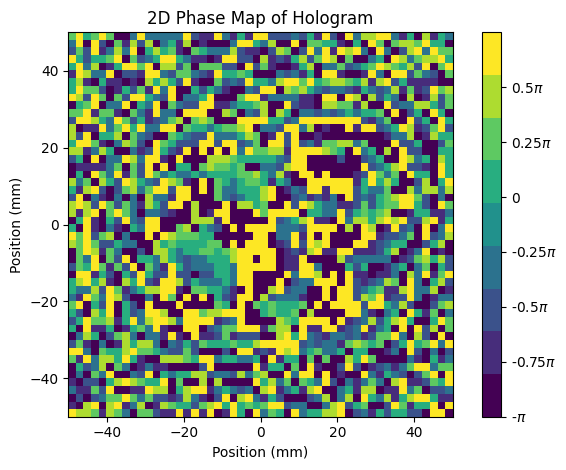

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

size_x = np.array(1 * mm * 100 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

extent = [-size_x, size_x, -size_x, size_x]

phase_map = setup.hologram.q_phase - 2 * torch.pi # 100 x 100
upsample_phase_map = nn.functional.interpolate(phase_map, size=[50, 50], mode='nearest')
#aperture = setup.hologram.Mask # 200 x 200
phase_map = upsample_phase_map #* aperture
phase_map = phase_map.squeeze(0,1).detach().cpu().numpy()

cmap = plt.get_cmap('viridis', 9)

fig, ax = plt.subplots()

cax = ax.imshow(phase_map, extent=extent, cmap=cmap)
ax.set_title('2D Phase Map of Hologram')
ax.set_xlabel("Position (" + unit_axis + ")")
ax.set_ylabel("Position (" + unit_axis + ")")

# Add a discrete colorbar with fractional π labels
ticks = np.linspace(-np.pi, np.pi, 9)  # Positions for the ticks
ticks = ticks[:-1]
tick_labels = ['-$\pi$', '-0.75$\pi$', '-0.5$\pi$', '-0.25$\pi$', '0', '0.25$\pi$', '0.5$\pi$', '0.75$\pi$']  # LaTeX formatted labels
cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)  # Set custom tick labels

plt.tight_layout()
plt.show()


array([-1.        , -0.75      , -0.50000006, -0.24999994,  0.        ,
        0.24999994,  0.50000006,  0.7499998 ], dtype=float32)